## Analysis for multiclass classification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

def save(df, savepath, filename):
    '''Takes in a dataframe and a filename for saving to csv'''
    Path(savepath).mkdir(parents=True, exist_ok=True) #Make the folder if it already doesn't exist
    df.to_csv(f"{savepath}{filename}.csv", header=False)

In [5]:
authors_data = pd.read_csv("../data/interim/author_data.csv")
comments_data = pd.read_csv("../data/interim/comment_data.csv")
gilds_data = pd.read_csv("../data/interim/gildings_data.csv")
threads_data = pd.read_csv("../data/interim/threads_data.csv")

In [6]:
from datetime import timedelta
import time

def toDays(x, currentime):
    '''Takes in created_utc time (Unix time, in seconds) and current time. Calculates
    age and returns the number of days'''
    d = timedelta(seconds=currentime-x)
    return d.days

def process_dates(data, new_column):
    '''Convert the created_utc time to datetime, fetch the days and place it
    in a new column. Also removes the original created_utc column'''
    df = data.copy()
    now = time.time() #This will differ everytime, but the change will be constant across all the rows.
    df[new_column] = df.created_utc.map(lambda x: toDays(x, now))
    return df.drop(["created_utc"], axis=1)
    
authors = process_dates(authors_data, "acc_age_days")
comments = process_dates(comments_data, "comment_age_days")

In [7]:
def process_gilds(data):
    '''Takes in the gilds dataframe, evaluates the dictionary (gildings columns), converts it into columns
    and returns the result'''
    df = data.copy()
    '''Pandas doesn't recognize the dictionary in the gildings column, so we evaluate them and 
    then apply pd.Series to convert them into three columns for further processing, corresponding to gold, 
    silver and platinum gilds/awards'''
    all_gildings = df.gildings.apply(lambda x: dict(eval(x))).apply(pd.Series).fillna(0)
    df = pd.concat([df, all_gildings], axis=1)
    return df.drop(["gildings"], axis=1)
    
gilds = process_gilds(gilds_data)

In [8]:
gilded_comments = gilds.merge(comments, how='inner', on='comment_ids')
gilded_all = gilded_comments.merge(authors, how='inner', on='author_ids')
gilded_all = gilded_all.filter(items=["gid_1", "gid_2", "gid_3", 
                                        "ups", "comment_karma", "link_karma", 
                                        "is_premium", "comment_age_days", "acc_age_days"], axis=1)

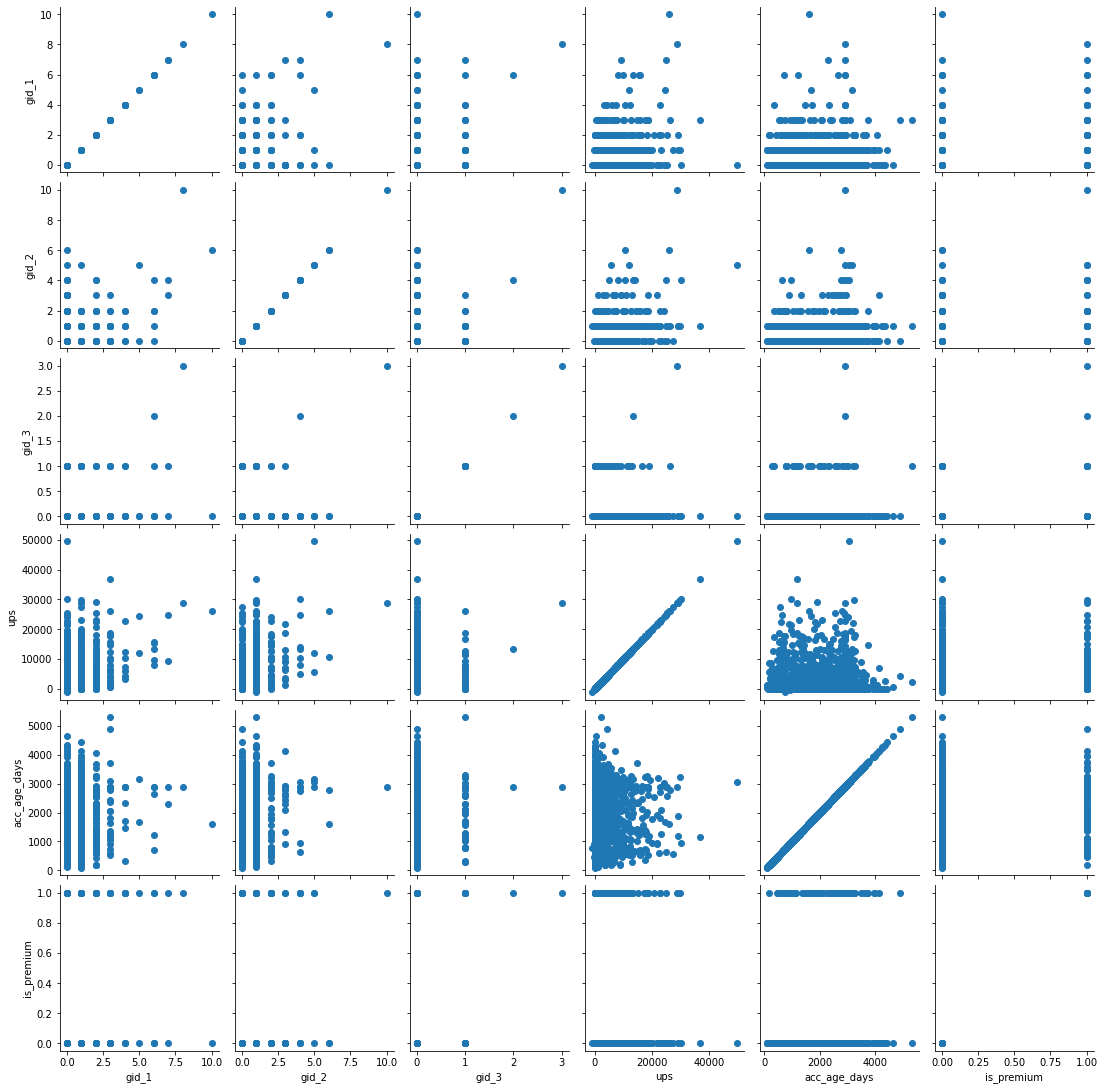

In [9]:
g = sns.PairGrid(gilded_all, vars=["gid_1", "gid_2", "gid_3", "ups", "acc_age_days", "is_premium"])
g.map(plt.scatter)

The premium status of the reddit account don't seem to add anything of value, so let's try another set without it. Let's also isolate the graph for each gilding.

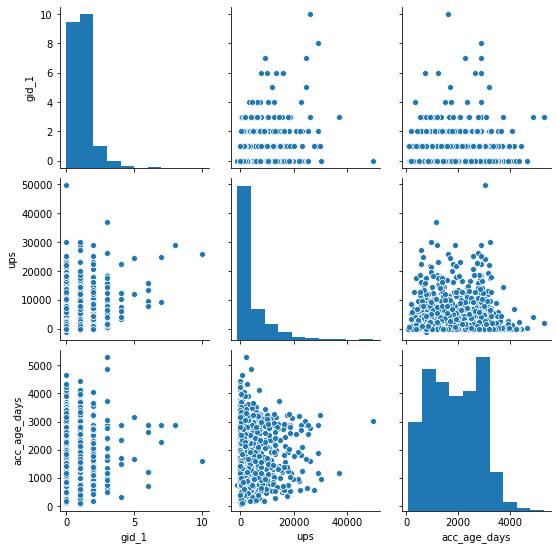

In [10]:
sns.pairplot(gilded_all, vars=["gid_1", "ups", "acc_age_days"])

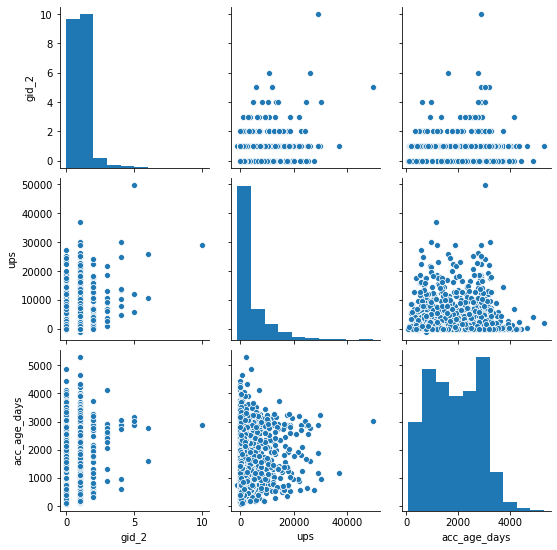

In [11]:
sns.pairplot(gilded_all, vars=["gid_2", "ups", "acc_age_days"])

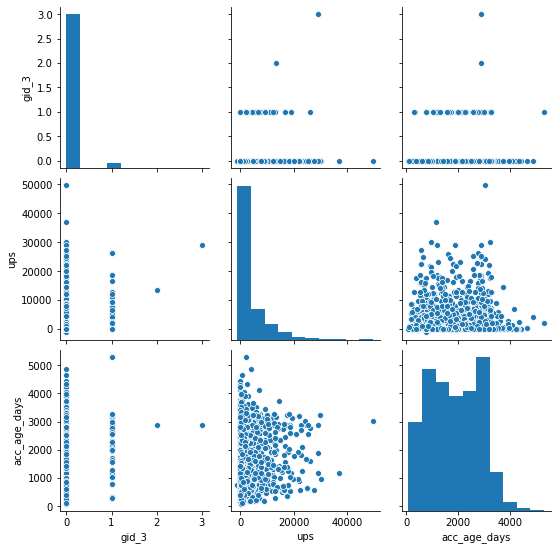

In [12]:
sns.pairplot(gilded_all, vars=["gid_3", "ups", "acc_age_days"])

In [13]:
gilded_all.describe()

,gid_1,gid_2,gid_3,ups,comment_karma,link_karma,comment_age_days,acc_age_days
count,1244.000000,1244.000000,1244.000000,1244.000000,1.244000e+03,1.244000e+03,1244.000000,1244.000000
mean,0.733119,0.624598,0.033762,3507.286977,3.287666e+05,2.354122e+05,396.991961,1862.239550
std,0.924066,0.769327,0.197698,5512.734342,1.291442e+06,8.520981e+05,243.002786,972.170546
min,0.000000,0.000000,0.000000,-1070.000000,-1.000000e+02,1.000000e+00,4.000000,93.000000
25%,0.000000,0.000000,0.000000,80.750000,8.533500e+03,4.097500e+02,182.000000,1026.000000
50%,1.000000,1.000000,0.000000,1057.500000,2.719750e+04,3.139500e+03,429.000000,1831.000000
75%,1.000000,1.000000,0.000000,4590.500000,9.681900e+04,1.474250e+04,505.250000,2723.250000
max,10.000000,10.000000,3.000000,49523.000000,1.885974e+07,8.341261e+06,1274.000000,5299.000000


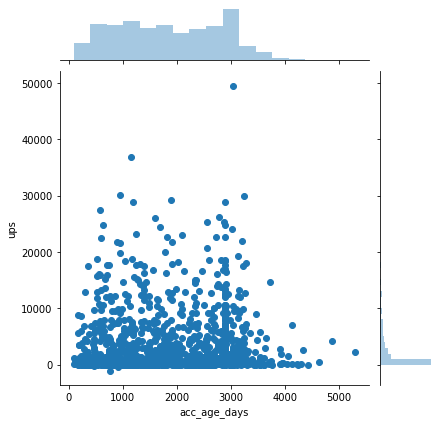

In [14]:
sns.jointplot(x="acc_age_days", y="ups", data=gilded_all)